## POS tagging using modified Viterbi

Essentially working with <b>HMM-based</b> <I>POS tagger</I> and implementing <b>Viterbi</b> algorithm using Penn Treebank there is some loss of accuracy due to algorithm not able to correctly tag the unknown words(not present in training set).
Thus algorithm tag arbitrarily chooses first tag to those words.

<I>We have been provided with Treebank dataset of NLTK with the 'universal' tagset having 12 coarse tag classes</I>

We aim at correcting the incorrect tagging of unknown words using two techniques:
- Using <b>morphological cues</b> to correctly tag the unknown words in the corpus
- <b>Modifying Viterbi algorithm</b> so that it only considers one among emission/transition probabilities. As for unknown words emission probability is zero.

<b>Goals:</b>
1. Vanilla Viterbi for POS tagging without dealing with unknown words 
2. Solve unknown word problem by modifying Viterbi also using lexicon, rule-based, probabilistic etc.
3. Compare tagging accuracy after modifications in Viterbi algo
4. List down at least three cases from the sample test file (i.e. unknown word-tag pairs) which were incorrectly tagged by the original Viterbi POS tagger and got corrected after your modifications. 

***

## 1. Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.tag import DefaultTagger 
test_file='Test_sentences.txt'

#### 1.1 Reading the Treebank tagged sentences

In [2]:
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

<b>First few tagged sentences</b>

In [3]:
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In the list mentioned above, each element of the list is a sentence. Also, note that each sentence ends with a full stop '.' whose POS tag is also a '.'. Thus, the POS tag '.' demarcates the end of a sentence.

Also, we do not need the corpus to be segmented into sentences, but can rather use a list of (word, tag) tuples. Let's convert the list into a (word, tag) tuple.

<b>Converting the list of sents to a list of (word, pos tag) tuples</b>

In [4]:
tagged_words = [tup for sent in nltk_data for tup in sent]
print('Length of tagged words: ',len(tagged_words))
print('10 sample tagged words with word and POS tag: ',tagged_words[:10])

Length of tagged words:  100676
10 sample tagged words with word and POS tag:  [('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET')]


We now have a list of about `100676` (word, tag) tuples. Let's now do some exploratory analyses.

## 2. Exploratory Analysis

Let's now conduct some basic exploratory analysis to understand the tagged corpus. 



#### 2.1 Number of unique POS tags in the corpus

In [5]:
# We can use the set() function on the list of tags to get a unique set of tags, 
# and compute its length
tags = [pair[1] for pair in tagged_words]
unique_tags = set(tags)
len(unique_tags)

12

There are 12 unique tags in the corpus as expected

#### 2.2 Most frequent tags in the corpus

In [6]:
# To count the frequency of elements in a list, the Counter() class from collections
# module is very useful, as shown below

from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 28867,
         '.': 11715,
         'NUM': 3546,
         'ADJ': 6397,
         'VERB': 13564,
         'DET': 8725,
         'ADP': 9857,
         'CONJ': 2265,
         'X': 6613,
         'ADV': 3171,
         'PRT': 3219,
         'PRON': 2737})

Most frequent tags include `Noun`, `.` ,`NUM` etc

#### 2.3 Most frequent words in the corpus

In [7]:
words = [pair[0] for pair in tagged_words]
word_counts = Counter(words)
word_counts.most_common()

[(',', 4885),
 ('the', 4045),
 ('.', 3828),
 ('of', 2319),
 ('to', 2164),
 ('a', 1878),
 ('in', 1572),
 ('and', 1511),
 ('*-1', 1123),
 ('0', 1099),
 ('*', 965),
 ("'s", 864),
 ('for', 817),
 ('that', 807),
 ('*T*-1', 806),
 ('*U*', 744),
 ('$', 718),
 ('The', 717),
 ('``', 702),
 ("''", 684),
 ('is', 671),
 ('said', 628),
 ('on', 490),
 ('it', 476),
 ('%', 446),
 ('by', 429),
 ('at', 402),
 ('with', 387),
 ('from', 386),
 ('as', 385),
 ('million', 383),
 ('Mr.', 375),
 ('*-2', 372),
 ('are', 369),
 ('was', 367),
 ('be', 356),
 ('*T*-2', 345),
 ('has', 339),
 ('its', 332),
 ("n't", 325),
 ('have', 323),
 ('an', 316),
 ('or', 291),
 ('will', 281),
 ('company', 260),
 ('--', 230),
 ('he', 230),
 ('which', 225),
 ('U.S.', 221),
 ('year', 212),
 ('they', 210),
 ('says', 210),
 ('would', 209),
 ('about', 206),
 ('more', 198),
 ('were', 197),
 ('In', 197),
 ('this', 184),
 ('their', 181),
 ('than', 180),
 ('market', 176),
 (';', 171),
 ('New', 165),
 ('had', 165),
 ('who', 163),
 ('new', 162

As seen most frequent words appearing in corpus are `,`,`the`,`.`,`of` etc 

#### 2.4 The most common tags can be seen using the most_common() method of Counter


In [8]:
tag_counts.most_common(5)

[('NOUN', 28867), ('VERB', 13564), ('.', 11715), ('ADP', 9857), ('DET', 8725)]

Thus, NOUN is the most common tag followed by `VERB`, `.`, `ADP`, `DET` etc.

#### 2.5 Checking most commonly assigned tag to the random words

In [9]:
bank = [pair for pair in tagged_words if pair[0].lower() == 'the']
Counter(bank)

Counter({('the', 'DET'): 4038,
         ('The', 'DET'): 713,
         ('The', 'NOUN'): 4,
         ('the', 'NOUN'): 1,
         ('the', 'ADJ'): 5,
         ('THE', 'DET'): 2,
         ('the', 'NUM'): 1})

Most common tagged assigned to tag `the` is `DET`

In [10]:
executive = [pair for pair in tagged_words if pair[0].lower() == 'executive']
Counter(executive)

Counter({('executive', 'NOUN'): 40, ('executive', 'ADJ'): 28})

Most common tagged assigned to tag `executive` is `NOUN`

#### Observing some rules which can potentially be used for POS tagging. 

#### 2.6 Number of words with the tag 'VERB' (verb, past tense) end with 'ed'

In [11]:
past_tense_verbs = [pair for pair in tagged_words if pair[1]=='VERB']
ed_verbs = [pair for pair in past_tense_verbs if pair[0].endswith('ed')]
print('Percentage of VERB tagged words ending with `ed`: ',(len(ed_verbs) / len(past_tense_verbs)*100),'%')
ed_verbs[:20]

Percentage of VERB tagged words ending with `ed`:  20.694485402536124 %


[('named', 'VERB'),
 ('used', 'VERB'),
 ('caused', 'VERB'),
 ('exposed', 'VERB'),
 ('reported', 'VERB'),
 ('stopped', 'VERB'),
 ('reported', 'VERB'),
 ('studied', 'VERB'),
 ('led', 'VERB'),
 ('used', 'VERB'),
 ('replaced', 'VERB'),
 ('worked', 'VERB'),
 ('died', 'VERB'),
 ('expected', 'VERB'),
 ('diagnosed', 'VERB'),
 ('expected', 'VERB'),
 ('studied', 'VERB'),
 ('industrialized', 'VERB'),
 ('owned', 'VERB'),
 ('industrialized', 'VERB')]

#### 2.6 Number of words with the tag 'VERB' end with 'ing'

In [12]:
 participle_verbs = [pair for pair in tagged_words if pair[1]=='VERB']
ing_verbs = [pair for pair in participle_verbs if pair[0].endswith('ing')]
print('Percentage of VERB tagged words ending with `ing`: ',(len(ing_verbs) / len(participle_verbs))*100,'%')
ing_verbs[:20]

Percentage of VERB tagged words ending with `ing`:  10.852255971689766 %


[('publishing', 'VERB'),
 ('causing', 'VERB'),
 ('using', 'VERB'),
 ('bring', 'VERB'),
 ('talking', 'VERB'),
 ('having', 'VERB'),
 ('making', 'VERB'),
 ('surviving', 'VERB'),
 ('including', 'VERB'),
 ('including', 'VERB'),
 ('according', 'VERB'),
 ('remaining', 'VERB'),
 ('according', 'VERB'),
 ('declining', 'VERB'),
 ('rising', 'VERB'),
 ('yielding', 'VERB'),
 ('waiving', 'VERB'),
 ('holding', 'VERB'),
 ('holding', 'VERB'),
 ('cutting', 'VERB')]

#### 2.7 Number of words with the tag 'ADV' end with 'ly'

In [13]:
participle_adverbs = [pair for pair in tagged_words if pair[1]=='ADV']
ly_adverbs = [pair for pair in participle_adverbs if pair[0].endswith('ly')]
print('Percentage of ADV tagged words ending with `ly`: ',(len(ly_adverbs) / len(participle_adverbs))*100,'%')
ly_adverbs[:20]

Percentage of ADV tagged words ending with `ly`:  28.129927467675813 %


[('unusually', 'ADV'),
 ('closely', 'ADV'),
 ('recently', 'ADV'),
 ('probably', 'ADV'),
 ('stringently', 'ADV'),
 ('easily', 'ADV'),
 ('virtually', 'ADV'),
 ('particularly', 'ADV'),
 ('mechanically', 'ADV'),
 ('relatively', 'ADV'),
 ('only', 'ADV'),
 ('closely', 'ADV'),
 ('Typically', 'ADV'),
 ('currently', 'ADV'),
 ('heavily', 'ADV'),
 ('currently', 'ADV'),
 ('formerly', 'ADV'),
 ('Previously', 'ADV'),
 ('typically', 'ADV'),
 ('sharply', 'ADV')]

#### Some tags are more likely to appear after certain other tags. 
For e.g. most nouns NN are usually followed by determiners DET ("The/DETT constitution/NOUN"), adjectives ADJ usually precede a noun NN (" A large/ADJ building/NOUN"), etc. 

#### 2.8 Fraction of adjectives ADJ followed by a noun NOUN

In [14]:
# create a list of all tags (without the words)
tags = [pair[1] for pair in tagged_words]

# create a list of ADJ tags
jj_tags = [t for t in tags if t == 'ADJ']

# create a list of (ADJ, NOUN) tags
jj_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='ADJ' and tags[index+1]=='NOUN']

print('Total adjective tags: ',len(jj_tags))
print('Total adjective|noun tags: ',len(jj_nn_tags))
print('Percentage of adjectives followed by noun: ',(len(jj_nn_tags) / len(jj_tags))*100,'%')

Total adjective tags:  6397
Total adjective|noun tags:  4474
Percentage of adjectives followed by noun:  69.93903392215101 %


#### 2.9 Fraction of determiners DET followed by a noun NOUN

In [15]:
dt_tags = [t for t in tags if t == 'DET']
dt_nn_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='DET' and tags[index+1]=='NOUN']

print('Total determinant tags: ',len(dt_tags))
print('Total determinant|noun tags: ',len(dt_nn_tags))
print('Percentage of determinant followed by noun: ',(len(dt_nn_tags) / len(dt_tags))*100,'%')

Total determinant tags:  8725
Total determinant|noun tags:  5569
Percentage of determinant followed by noun:  63.82808022922636 %


#### 2.10 Fraction of particle PRT followed by a verb VERB

In [16]:
prt_tags = [t for t in tags if t == 'PRT']
prt_vb_tags = [(t, tags[index+1]) for index, t in enumerate(tags) 
              if t=='PRT' and tags[index+1]=='VERB']

print('Total particle tags: ',len(prt_tags))
print('Total particle|verb tags: ',len(prt_vb_tags))
print('Percentage of particle followed by verb: ',(len(prt_vb_tags) / len(prt_tags))*100,'%')

Total particle tags:  3219
Total particle|verb tags:  1291
Percentage of particle followed by verb:  40.10562286424356 %


Thus, we see that the probability of certain tags appearing after certain other tags is quite high, and this fact can be used to build quite efficient POS tagging algorithms. 

## 3. Splitting into Train and Test Sets

In [17]:
# splitting into train and test
train_set, validation_set = train_test_split(nltk_data, test_size=0.05, train_size=0.95,random_state=101)

print('Training set size: ',len(train_set))
print('Test set size: ',len(validation_set))


Training set size:  3718
Test set size:  196


<b>Checking sample data in test and validation sets</b>

In [18]:
print('##Train set second column: ',train_set[:2])
print()
print('##Validation set second column: ',validation_set[:2])

##Train set second column:  [[('Reliance', 'NOUN'), ('confirmed', 'VERB'), ('the', 'DET'), ('filing', 'NOUN'), ('but', 'CONJ'), ('would', 'VERB'), ("n't", 'ADV'), ('elaborate', 'VERB'), ('.', '.')], [('*', 'X'), ('Encouraging', 'VERB'), ('long-term', 'ADJ'), ('investing', 'NOUN'), ('.', '.')]]

##Validation set second column:  [[('The', 'DET'), ('company', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('is', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('process', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('phasing', 'VERB'), ('out', 'PRT'), ('John', 'NOUN'), ('Deere', 'NOUN'), (',', '.'), ('its', 'PRON'), ('current', 'ADJ'), ('source', 'NOUN'), ('of', 'ADP'), ('production', 'NOUN'), ('for', 'ADP'), ('midsized', 'ADJ'), ('motor', 'NOUN'), ('home', 'NOUN'), ('chassis', 'NOUN'), ('.', '.')], [('Douglas', 'NOUN'), ('Madison', 'NOUN'), (',', '.'), ('a', 'DET'), ('corporate', 'ADJ'), ('trader', 'NOUN'), ('with', 'ADP'), ('Bank', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('in', 'ADP'), ('Lo

#### 3.1 Getting list of tagged words from training and validation sets

In [19]:
train_tagged_words = [tup for sent in train_set for tup in sent]
print('Number of tags in training set:',len(train_tagged_words))
validation_tagged_words = [tup for sent in validation_set for tup in sent]
print('Number of tags in validation set:',len(validation_tagged_words))

Number of tags in training set: 95547
Number of tags in validation set: 5129


#### 3.2 Getting list of tokens from training and validation sets

In [20]:
train_tokens = [pair[0] for pair in train_tagged_words]
print('Sample train tokens:',train_tokens[:10])
validation_tokens = [pair[0] for pair in validation_tagged_words]
print('Sample validation tokens:',validation_tokens[:10])

Sample train tokens: ['Reliance', 'confirmed', 'the', 'filing', 'but', 'would', "n't", 'elaborate', '.', '*']
Sample validation tokens: ['The', 'company', 'said', '0', 'it', 'is', 'in', 'the', 'process', 'of']


#### 3.3 Getting list of vocabulary/words from training and validation sets

In [21]:
train_vocabulary = set(train_tokens)
print('Train vocabulary: ',len(train_vocabulary))
validation_vocabulary = set(validation_tokens)
print('Validation vocabulary: ',len(validation_vocabulary))

Train vocabulary:  12100
Validation vocabulary:  1877


#### 3.4 Fetching Known or common vocabulary/words

In [22]:
#We check the training set for known set of words and compare them with validation set and bring out common words from two sets
known_words=list(set(train_vocabulary).intersection(set(validation_vocabulary)))
print('Number of common/known words: ',len(known_words))
print('Some known/common words in both train set and validation sets: ',known_words[:10])


Number of common/known words:  1569
Some known/common words in both train set and validation sets:  ['represent', 'Mr.', 'Nixon', 'Indianapolis', 'cause', "n't", 'billion', 'financial', 'rule', 'just']


#### 3.4 Fetching unknown vocabulary/words
<a id='Unknown_Words'></a>

In [23]:
#We check the which words from validation sets are not present in training set as POS tagging cannot identify them
unknown_words=list(set(validation_vocabulary).difference(set(train_vocabulary)))
print('Number of unknown words: ',len(unknown_words))
print('Some unknown words in both train set and validation sets: ',unknown_words[:10])


Number of unknown words:  308
Some unknown words in both train set and validation sets:  ['1,298', 'Attorney', 'Editorials', 'investor-relations', 'fashion', 'Barbaresco', 'muted', 'championing', 'vagabond', '*-128']


#### 3.4 Fetching number of unique tags in train and validation sets

In [24]:
train_tags = set([pair[1] for pair in train_tagged_words])
print('Number of unique tags in train set: ',len(train_tags))
validation_tags = set([pair[1] for pair in validation_tagged_words])
print('Number of unique tags in validation set: ',len(validation_tags))
print('Tags in train corpus: ',train_tags)
print('Tags in validation corpus: ',validation_tags)

Number of unique tags in train set:  12
Number of unique tags in validation set:  12
Tags in train corpus:  {'ADV', 'CONJ', 'ADP', 'VERB', 'NUM', 'PRON', 'X', 'NOUN', 'PRT', '.', 'DET', 'ADJ'}
Tags in validation corpus:  {'ADV', 'ADP', 'CONJ', 'VERB', 'NUM', 'PRON', 'X', 'NOUN', 'PRT', '.', 'DET', 'ADJ'}


#### 3.5 Fetching probability of each tag in train set

In [25]:
map_of_tags=dict(Counter([tag for word,tag in train_tagged_words]))

prob_tag=dict()
total_tags=sum(map_of_tags.values())
for k,v in map_of_tags.items():
    prob_tag.update({k:(v/total_tags)})
print(prob_tag)
    

{'NOUN': 0.2862674913916711, 'VERB': 0.1351167488251855, 'DET': 0.08666938784053921, 'CONJ': 0.02251248076862696, 'ADV': 0.031597015081582885, '.': 0.11641391147812072, 'X': 0.06576867928872701, 'ADJ': 0.06351847781719991, 'ADP': 0.0978889970381069, 'PRT': 0.03176447193527793, 'PRON': 0.0273373313657153, 'NUM': 0.035145007169246546}


## 4. POS Tagging Algorithm - HMM

We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word. 

In other words, to every word w, assign the tag t that maximises the likelihood P(t/w). Since P(t/w) = P(w/t). P(t) / P(w), after ignoring P(w), we have to compute P(w/t) and P(t).


P(w/t) is basically the probability that given a tag (say NOUN), what is the probability of it being w (say 'building'). This can be computed by computing the fraction of all NOUNs which are equal to w, i.e. 

P(w/t) = count(w, t) / count(t). 


The term P(t) is the probability of tag t, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NOUN will depend only on the previous tag t(n-1). So for e.g. if t(n-1) is a ADJ, then t(n) is likely to be an NOUN since adjectives often precede a noun (blue coat, tall building etc.).


Given the penn treebank tagged dataset, we can compute the two terms P(w/t) and P(t) and store them in two large matrices. The matrix of P(w/t) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero. 


#### 4.1 Emission Probabilities

In [26]:
# computing P(w/t) and storing in T x V matrix
t = len(train_tags)
v = len(train_vocabulary)
w_given_t = np.zeros((t, v))

In [27]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [28]:
# examples

# said
print("\n", "said")
print(word_given_tag('said', 'VERB'))
print(word_given_tag('said', 'ADJ'))
print(word_given_tag('said', 'ADV'), "\n")

# smooth
print("\n", "smooth")
print(word_given_tag('smooth', 'ADJ'))
print(word_given_tag('smooth', 'VERB'))
print(word_given_tag('smooth', 'ADV'))

# U.S.
print("\n", "U.S.")
print(word_given_tag('U.S.', 'NOUN'))
print(word_given_tag('U.S.', 'VERB'))


 said
(597, 12910)
(0, 6069)
(0, 3019) 


 smooth
(1, 6069)
(0, 12910)
(0, 3019)

 U.S.
(210, 27352)
(0, 12910)


#### Observation:
- 'said' appeared as verb 597 times out of total 12910 verbs in corpus which is more than any other tag for the same word


#### 4.2 Transition Probabilities

In [29]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [30]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADJ'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1(',', 'NOUN'))
print(t2_given_t1('PRT', 'PRT'))
print(t2_given_t1('VERB', 'NOUN'))

(4246, 6069)
(4246, 6069)
(5284, 8281)
(1421, 12910)
(0, 27352)
(5, 3035)
(4039, 27352)


#### Observation:
- NOUN appearing after adjective(ADJ) or determinant(DET) or verb(VERB) in corpus is more than any other tag 

<b>P(tag|start) is same as P(tag|'.')<b>

In [31]:
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))



(1928, 11123)
(991, 11123)
(2472, 11123)


#### NOUN starting a sentence has more probability

#### 4.3 Creating t x t transition matrix of tags

In [32]:
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
tags_matrix = np.zeros((len(train_tags), len(train_tags)), dtype='float32')
for i, t1 in enumerate(list(train_tags)):
    for j, t2 in enumerate(list(train_tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [33]:
tags_matrix

array([[8.04902315e-02, 6.95594586e-03, 1.18582316e-01, 3.43491226e-01,
        3.04736663e-02, 1.49055980e-02, 2.31864862e-02, 3.14673744e-02,
        1.42431268e-02, 1.37131497e-01, 6.98906928e-02, 1.29181847e-01],
       [5.53231053e-02, 4.64900048e-04, 5.25337048e-02, 1.56671315e-01,
        3.99814025e-02, 5.81125058e-02, 8.83310102e-03, 3.49139929e-01,
        4.64900024e-03, 3.48675027e-02, 1.21338911e-01, 1.18084610e-01],
       [1.40062012e-02, 9.62258084e-04, 1.68929752e-02, 8.33956990e-03,
        6.22260235e-02, 7.00310096e-02, 3.44274566e-02, 3.20966542e-01,
        1.38992839e-03, 3.90249118e-02, 3.24708641e-01, 1.07024483e-01],
       [8.19519758e-02, 5.57707204e-03, 9.20216888e-02, 1.69248641e-01,
        2.28505041e-02, 3.57862115e-02, 2.17505813e-01, 1.10069714e-01,
        3.06738969e-02, 3.49341594e-02, 1.34391949e-01, 6.49883822e-02],
       [2.97796307e-03, 1.36986300e-02, 3.60333547e-02, 1.87611673e-02,
        1.84931502e-01, 1.48898154e-03, 2.10541993e-01, 3.50

#### 4.4 Convert the matrix to a df for better readability

In [34]:
tags_df = pd.DataFrame(tags_matrix, columns = list(train_tags), index=list(train_tags))

In [35]:
tags_df

,ADV,CONJ,ADP,VERB,NUM,PRON,X,NOUN,PRT,.,DET,ADJ
ADV,0.080490,0.006956,0.118582,0.343491,0.030474,0.014906,0.023186,0.031467,0.014243,0.137131,0.069891,0.129182
CONJ,0.055323,0.000465,0.052534,0.156671,0.039981,0.058113,0.008833,0.349140,0.004649,0.034868,0.121339,0.118085
ADP,0.014006,0.000962,0.016893,0.008340,0.062226,0.070031,0.034427,0.320967,0.001390,0.039025,0.324709,0.107024
VERB,0.081952,0.005577,0.092022,0.169249,0.022851,0.035786,0.217506,0.110070,0.030674,0.034934,0.134392,0.064988
NUM,0.002978,0.013699,0.036033,0.018761,0.184932,0.001489,0.210542,0.350208,0.026504,0.117332,0.003276,0.034247
PRON,0.034074,0.005360,0.022971,0.485452,0.006508,0.007657,0.089969,0.210949,0.013017,0.040965,0.009954,0.073124
X,0.024984,0.010662,0.142584,0.203851,0.002864,0.055538,0.076384,0.062381,0.185232,0.163590,0.054742,0.017187
NOUN,0.017074,0.042666,0.176514,0.147667,0.009542,0.004607,0.029175,0.263564,0.043397,0.240604,0.012942,0.012248
PRT,0.010214,0.002306,0.020099,0.405272,0.056672,0.017792,0.013509,0.247776,0.001647,0.043822,0.097858,0.083031
.,0.052324,0.057538,0.091342,0.089095,0.081003,0.066349,0.026971,0.222242,0.002427,0.093320,0.173335,0.043963


#### 4.5 Starting probability of all the tags in corpus

In [36]:
tags_df.loc['.', :]

ADV     0.052324
CONJ    0.057538
ADP     0.091342
VERB    0.089095
NUM     0.081003
PRON    0.066349
X       0.026971
NOUN    0.222242
PRT     0.002427
.       0.093320
DET     0.173335
ADJ     0.043963
Name: ., dtype: float32

#### 4.6 Heatmap of tags matrix

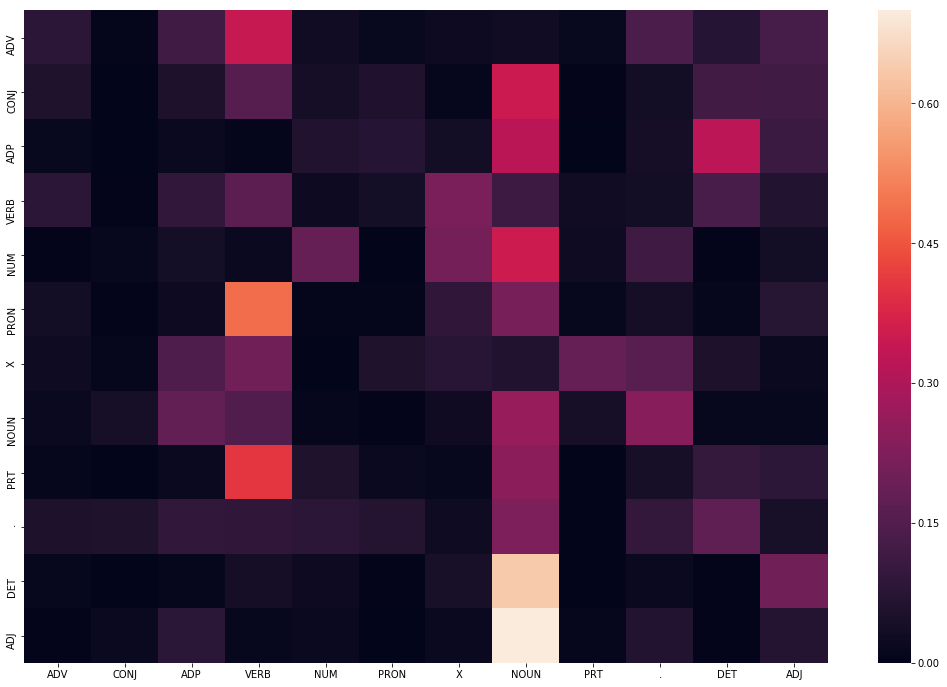

In [37]:
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


#### 4.7 frequent tags (filtering the df to get P(t2, t1) > 0.5)

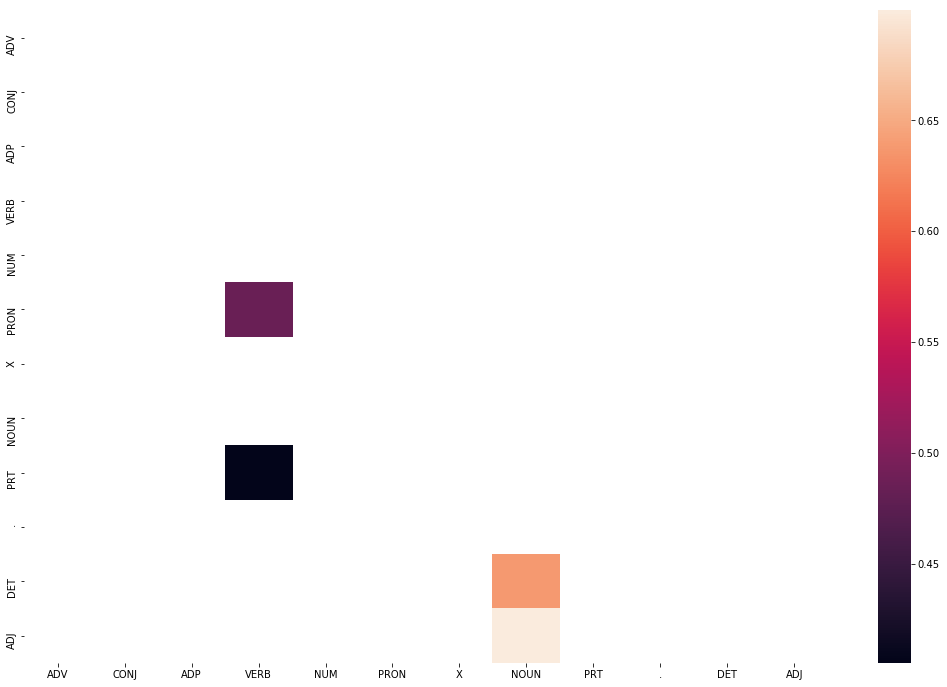

In [38]:
tags_frequent = tags_df[tags_df>0.40]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

#### We observe that probability is more for adjective followed by noun . Example: attractive person, beautiful place etc

## 5. Building the Vanilla Viterbi Algorithm based POS tagger

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.') 

In [39]:
print('Total tagged words in training set: ',len(train_tagged_words))

Total tagged words in training set:  95547


In [40]:
T = list(set([pair[1] for pair in train_tagged_words]))
T.sort()


#### 5.1 Making Vanilla Viterbi Heuristic function to tag the given words 

<b>Vanilla Viterbi</b>: The general viterbi algorithm that tags words based on the state probability i.e. based on maximum of (emmission_probability*transition_probability) for a given word

In [41]:
# Vanilla Viterbi Heuristic
def Vanilla_Viterbi(words):
    state = []
    #T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                #at start of sentence
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            #computing state probability
            state_probability = emission_p * transition_p    
            p.append(state_probability)
         
        
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


In [42]:
# list of tagged words
test_run_base = [sent for sent in validation_tagged_words]

# list of untagged words
test_tagged_words = [sent[0] for sent in validation_tagged_words]


#### 5.2 Evaluating on Validation Set and identify incorrect tags

In [43]:
# Running on entire validation dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of validation dataset

def evaluate_test(test_set,tagger=None,viterbi_call=Vanilla_Viterbi):
   
    
    # tagging the test sentences
    start = time.time()
    tagged_seq=None
    
    #calling appropriate Viterbi call according to parameter passed along with tagger provided
    if viterbi_call==Vanilla_Viterbi:    
        tagged_seq = Vanilla_Viterbi(test_tagged_words)
    else:
        tagged_seq = viterbi_call(test_tagged_words,custom_tagger=tagger)
       
    #calculating execution time for query
    end = time.time()
    difference = end-start
    
    print("Time taken in seconds: ", difference)
    print(tagged_seq)
    
    #calculating accuracy
    check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
    accuracy = len(check)/len(tagged_seq)
    print('accuracy',accuracy)
    print()
    #fetching incorrect tags
    incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
    print('Incorrect tagged cases: ',incorrect_tagged_cases)
    return [accuracy,incorrect_tagged_cases]


In [44]:
accuracy_vanilla,incorrect_tagged=evaluate_test(validation_set)

Time taken in seconds:  1021.981516122818
[('The', 'DET'), ('company', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('is', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('process', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('phasing', 'VERB'), ('out', 'PRT'), ('John', 'NOUN'), ('Deere', '.'), (',', '.'), ('its', 'PRON'), ('current', 'ADJ'), ('source', 'NOUN'), ('of', 'ADP'), ('production', 'NOUN'), ('for', 'ADP'), ('midsized', 'VERB'), ('motor', 'NOUN'), ('home', 'NOUN'), ('chassis', 'NOUN'), ('.', '.'), ('Douglas', 'NOUN'), ('Madison', 'NOUN'), (',', '.'), ('a', 'DET'), ('corporate', 'ADJ'), ('trader', 'NOUN'), ('with', 'ADP'), ('Bank', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('in', 'ADP'), ('Los', 'NOUN'), ('Angeles', 'NOUN'), (',', '.'), ('traced', '.'), ('the', 'DET'), ('dollar', 'NOUN'), ("'s", 'PRT'), ('recent', 'ADJ'), ('solid', 'ADJ'), ('performance', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('yen', 'NOUN'), ('to', 'PRT'), ('purchases', 'NOUN'), ('of', 'ADP'), ('securiti

#### Accuracy from Vanilla Viterbi on validation set :

In [45]:
print('accuracy: ',accuracy_vanilla)

accuracy:  0.909728992006239


#### Incorrect tagged cases:

In [46]:
print('Incorrect tagged cases: ',incorrect_tagged)

Incorrect tagged cases:  [[('John', 'NOUN'), (('Deere', '.'), ('Deere', 'NOUN'))], [('for', 'ADP'), (('midsized', 'VERB'), ('midsized', 'ADJ'))], [(',', '.'), (('traced', '.'), ('traced', 'VERB'))], [('another', 'DET'), (('wave', '.'), ('wave', 'NOUN'))], [('its', 'PRON'), (('Eveready', '.'), ('Eveready', 'NOUN'))], [('A', 'DET'), (('nickname', '.'), ('nickname', 'NOUN'))], [('to', 'PRT'), (('glamorize', '.'), ('glamorize', 'VERB'))], [("'s", 'PRT'), (('vagabond', '.'), ('vagabond', 'NOUN'))], [('vagabond', 'NOUN'), (('existence', '.'), ('existence', 'NOUN'))], [('Parliament', 'NOUN'), (('authorized', '.'), ('authorized', 'VERB'))], [('Minister', 'NOUN'), (('Miklos', '.'), ('Miklos', 'NOUN'))], [('Miklos', 'NOUN'), (('Nemeth', '.'), ('Nemeth', 'NOUN'))], [('was', 'VERB'), (('2,303,328', '.'), ('2,303,328', 'NUM'))], [('down', 'ADV'), (('2.6', '.'), ('2.6', 'NUM'))], [('an', 'DET'), (('eight-count', '.'), ('eight-count', 'ADJ'))], [('eight-count', 'ADJ'), (('indictment', '.'), ('indictm

<b>Incorrect tagged words</b>
<a id='Incorrect_Words'></a>

In [47]:
incorrect_tagged_words=[i[0] for i in [incorrect_word[1] for pair in incorrect_tagged for incorrect_word in pair][1::2]]
incorrect_tagged_words_vanilla=set(incorrect_tagged_words)
incorrect_tagged_words_vanilla
print('Incorrect tagged words size: ',len(incorrect_tagged_words_vanilla),' Incorrect tagged words: ',incorrect_tagged_words_vanilla)

Incorrect tagged words size:  405  Incorrect tagged words:  {'1,298', 'Attorney', 'Editorials', 'investor-relations', 'fashion', 'there', 'Barbaresco', 'muted', 'vagabond', 'championing', '*-128', 'Congressman', 'Carbide', 'overused', '*T*-222', 'glamorize', 'Soviet', 'tutorials', 'Mount', 'own', 'odd-year', 'Eveready', 'CSV', 'Professional', 'audit', "'", 'Anglia', 'wish', 'fund', 'cosmetic', 'highlight', 'opposite', '83', 'disseminate', 'pins', 'Delegates', '133.7', 'flood', 'centralized', 'Sherwin', '89,500', 'unethical', 'witches', 'such', 'Comtes', 'drooled', 'executes', 'Gingl', 'Excision', 'two-sevenths', 'yield', 'ballots', 'public', 'Warehouse', 'overseas', 'Meese', '94', 'encroaching', 'traced', 'provoked', 'much', 'high-polluting', 'Brands', 'top-level', 'Braun', 'dams', 'complicated', 'observance', 'high', 'Net', 'down', 'offensive', 'delisted', 'shivers', 'export', 'memo', '*-129', 'Texan', 'boogieman', 'schemes', 'verge', 'oust', 'opens', 'refund', 'qualified', 'critical'

#### 5.3 Evaluating on test set

In [48]:
## Function to test on test sentences
def check_tags_on_test_vanilla(sentence_test):
    words = word_tokenize(sentence_test)

    start = time.time()
    tagged_seq = Vanilla_Viterbi(words)
    end = time.time()
    difference = end-start
    print('Tag Sequence: ',tagged_seq)
    print(difference)
    return tagged_seq
    

<b>Results on Test Set:</b>
<a id='Vanilla_Tests_Results'></a>

In [49]:
#Executing Vanilla viterbi line by line on each sentence on test set
f = open(test_file)
reader = f.read()
sentences_test = reader.splitlines()
f.close()

test_vanilla_tag_seq=[]

i=1
for line in sentences_test:
    if line!=[]:
        print('Sentence '+str(i)+': ',line)
        test_vanilla_tag_seq.append(check_tags_on_test_vanilla(line))
        print()
        i=i+1
    



Sentence 1:  Android is a mobile operating system developed by Google.
Tag Sequence:  [('Android', '.'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', '.'), ('.', '.')]
1.9977316856384277

Sentence 2:  Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Tag Sequence:  [('Android', '.'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', '.'), ('worldwide', '.'), ('on', 'ADP'), ('smartphones', '.'), ('since', 'ADP'), ('2011', '.'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', '.'), ('.', '.')]
3.626295328140259

Sentence 3:  Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Tag Sequence:  [('Google', '.'), ('and', 'CONJ'), ('Twitter', '.'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', '.'), ('that', 'DET'), ('gave', 

<B>Number of unknown words in test set<B>

In [50]:
words_in_test=[]
for l in sentences_test:
    words_in_test.append(word_tokenize(l))
test_vocabulary = [item for sublist in words_in_test for item in sublist]
print('Words in test set: ',len(set(test_vocabulary)))
print('Unknown words in test set: ',len(list(set(test_vocabulary).difference(set(train_vocabulary)))))

Words in test set:  115
Unknown words in test set:  28


### Observation
<b>We can clearly see that many of the words are tagged incorrectly primarily because they were not present in the training dataset such as Google marked as '.', OS marked as '.', NASA marked as '.' etc.
These words should have been tagged as NOUN. Thus we will try and rectify our Viterbi algorithm.</b>

Some other observations:
- Accuracy from Vanilla viterbi is : `0.909728992006239 (~91%)`
- Number of tags in validation set identified incorrectlly from vanilla viterbi: `405`
- We can make out that some words are verbs , numbers and nouns looking at the sample data set. Thus we will try building morphological taggers based on rule based techniques to improve correctness of tags.


## 6. Solve the problem of unknown words

#### 6.1 Approach 1 

As we have seen  Vanilla viterbi is incapabe of identifying few words: 
    - Some proper nouns(NOUN) like Android , Google, Twitter etc and has identified them as '.'
    - Some verbs like(VERB) arriving, contested and has identified them as '.'
    - Some numbers(NUM) like 2015, 2018 and has identified them as '.'
    
Thus we have to build a more sophisticated Viterbi by including custome tagger based on morphological cues

#### 6.1.1 Rule-Based (Regular Expression) Tagger

Building a rule-based, or regular expression based tagger. In NLTK, the `RegexpTagger()` can be provided with handwritten regular expression patterns, as shown below.

Below, we specify regexes for past/present tense verbs ,  possesive nouns , plural nouns , cardinal numbers etc.. and finally, if none of the above rules are applicable to a word, we tag the most frequent tag NOUN.  

In [51]:
# A rule based tagging system based on morphological cues of english that will correctly identify 
# some tags based on prefixes and some words apprearing in the words

# 1st Rule: Matches any word that starts with alphabets(capital or small) and ends with 'ously' and tag them as 'ADV'

# 2nd Rule: Matches any comma separated numbers and tag them as 'NUM'

# 3rd Rule: Matches whole capital letters in english and tag the word as 'NOUN'.

# 4th Rule: Matches words ending with 's' and tag them as 'NOUN' as they can be possessive or plural nouns

# 5th Rule: Matches words ending with ed/ing/es/ied/ive/ould and tag them as 'VERB'

# 6th Rule: Matches words staring from alphabets and containing numbers to contain address like words and tag them as 'NOUN'

# 7th Rule: Matches numbers in any form (integers/float) and tag them as 'NUM'

# 8th Rule: Matches words ending with 'ive' or 'iest' and tag them as 'ADJ'

# 9th Rule: Matches any word having special characters along with number and tag it as 'X' 
#           which ideally cannot be assigned to real part of speech category

# 10th Rule: If all above regex do not work it , defaultly tags the word as 'NOUN'

def rule_based_tagger(word):
    patterns = [
        
        (r'[aA-zZ]+(ously)$', 'ADV'),                   # ending with ously
        (r'^[0-9]+(,[0-9]+)*$', 'NUM'),                 # comma separated numbers
        (r'^[A-Z]+([a-z]{1,2})?\.?$','NOUN'),           # English letters capitalization
        (r'[aA-zZ]+(\'s|s)$', 'NOUN'),                  # possessive nouns & plural nouns
        (r'[aA-zZ]+(ed|ing|es|ied|ould)$', 'VERB'),     # ending with ed/ing/es/ied/ive/ould
        (r'^[aA-zZ].*[0-9]+','NOUN'),                   # address like words which contains house number with street
        (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'),               # cardinal numbers, any number
        (r'[aA-zZ]+(ive|iest)$', 'ADJ'),                # words ending with ive and iest
        (r'^([*0|-|$].*)','X'),                         # Number having special characters *T*-117, 0
        (r'.*', 'NOUN')                                 # leftover any word as Noun 
        
    ]
    
    rule_based_tagger = nltk.RegexpTagger(patterns)    
    return rule_based_tagger.tag(word)

#### 6.1.2 Modifying Viterbi for rule based tagging

<b>Modified Viterbi</b>: The altered viterbi algorithm that handles unknown words(words there in validation set but not in training set) problem .

Emission probability becomes zero as the word is not there in training set.Thus based on the state probability i.e. based on maximum of (emmission_probability*transition_probability) for a given word we cannot identify tag of a given word , due to the fact that it will be always zero.

- Thus in this first approach we introduce rule based tagging mechanism to enhance the probability of unknown word being correctly tagged.

In [52]:
# Modified Viterbi Heuristic
def Modified_Viterbi_Rule_Based(words, custom_tagger=None):
    
    state = []
    #T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        sp = [] 
        ep = []
        tp = [] 
        for tag in T:
            if key == 0:
                #Depicts start of sentence
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            tp.append(transition_p)
            ep.append(emission_p)
            state_probability = emission_p * transition_p    
            sp.append(state_probability)
            
        max_p = max(sp)
        state_max = T[sp.index(max_p)]
        #condition for unknown word when state probability becomes zero (as emission probability=0)
        if max_p==0.0:
            #in case of rule based tagging
            if custom_tagger!=None:
                state_max=custom_tagger([word])[0][1]
        else:
            # getting state for which probability is maximum
            state_max = T[sp.index(max_p)] 
        state.append(state_max)
    return list(zip(words, state))



#### 6.1.3 Evaluating on Validation Set and identify incorrect tags

In [53]:
accuracy_modified_rulebased,incorrect_tagged=evaluate_test(validation_set,tagger=rule_based_tagger,viterbi_call=Modified_Viterbi_Rule_Based)

Time taken in seconds:  1070.4883422851562
[('The', 'DET'), ('company', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('is', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('process', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('phasing', 'VERB'), ('out', 'PRT'), ('John', 'NOUN'), ('Deere', 'NOUN'), (',', '.'), ('its', 'PRON'), ('current', 'ADJ'), ('source', 'NOUN'), ('of', 'ADP'), ('production', 'NOUN'), ('for', 'ADP'), ('midsized', 'VERB'), ('motor', 'NOUN'), ('home', 'NOUN'), ('chassis', 'NOUN'), ('.', '.'), ('Douglas', 'NOUN'), ('Madison', 'NOUN'), (',', '.'), ('a', 'DET'), ('corporate', 'ADJ'), ('trader', 'NOUN'), ('with', 'ADP'), ('Bank', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('in', 'ADP'), ('Los', 'NOUN'), ('Angeles', 'NOUN'), (',', '.'), ('traced', 'VERB'), ('the', 'DET'), ('dollar', 'NOUN'), ("'s", 'PRT'), ('recent', 'ADJ'), ('solid', 'ADJ'), ('performance', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('yen', 'NOUN'), ('to', 'PRT'), ('purchases', 'NOUN'), ('of', 'ADP'), ('s

#### Accuracy from Modified Viterbi on validation set :

In [54]:
print('accuracy: ',accuracy_modified_rulebased)

accuracy:  0.9561317995710665


#### Incorrect tagged cases:

In [55]:
print('Incorrect tagged cases: ',incorrect_tagged)

Incorrect tagged cases:  [[('for', 'ADP'), (('midsized', 'VERB'), ('midsized', 'ADJ'))], [('to', 'PRT'), (('glamorize', 'NOUN'), ('glamorize', 'VERB'))], [('an', 'DET'), (('eight-count', 'NOUN'), ('eight-count', 'ADJ'))], [('to', 'PRT'), (('manipulate', 'NOUN'), ('manipulate', 'VERB'))], [("'s", 'PRT'), (('planned', 'VERB'), ('planned', 'ADJ'))], [('lobbyists', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))], [('emissions', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [('to', 'PRT'), (('fuel', 'NOUN'), ('fuel', 'VERB'))], [('*-1', 'X'), (('unimpeded', 'VERB'), ('unimpeded', 'ADJ'))], [('the', 'DET'), (('subsequent', 'NOUN'), ('subsequent', 'ADJ'))], [('orders', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [('contract', 'NOUN'), (('down', 'ADP'), ('down', 'PRT'))], [('the', 'DET'), (('intermediate', 'NOUN'), ('intermediate', 'ADJ'))], [('.', '.'), (('Proper', 'NOUN'), ('Proper', 'ADJ'))], [('Proper', 'ADJ'), (('English', 'NOUN'), ('English', 'ADJ'))], [('the', 'DET'), (('highest-pitched', 'N

#### 6.1.4 Incorrect tagged words 
<a id='Incorrect_Words_Modified'></a>

In [56]:
incorrect_tagged_words=[i[0] for i in [incorrect_word[1] for pair in incorrect_tagged for incorrect_word in pair][1::2]]
incorrect_tagged_rulebased=set(incorrect_tagged_words)
print('Incorrect tagged words size: ',len(incorrect_tagged_rulebased),' Incorrect tagged words: ',incorrect_tagged_rulebased)

Incorrect tagged words size:  176  Incorrect tagged words:  {'as', 'NBC-owned', 'up', 'builds', 'gigantic', 'underlying', 'undiplomatic', 'fundamentally', 'manipulate', 'Midwestern', 'expendable', 'there', 'counteract', 'highest-pitched', '&', 'Proper', 'alleged', 'nominal', 'building', 'erect', 'due', 'glamorize', 'broke', 'Chinese', 'holding', 'Soviet', 'most', 'higher-salaried', 'Second', 'own', 'odd-year', 'present', 'shot', 'Professional', 'audit', 'appease', 'report', 'key', 'Federal', 'phase', 'wish', 'fund', 'cosmetic', 'borrowing', 'facial', 'highlight', 'third-highest', 'pay', 'move', 'opposite', 'disseminate', 'pins', 'Third', 'channel', 'All', 'state', 'more', 'ago', 'meatpacking', 'So', 'favored', 'Packaging', 'changes', 'unethical', 'related', 'net', 'such', 'executes', 'and', 'pre-1917', 'learn', 'yield', 'appropriate', 'trespass', 'off', 'talk', 'erroneous', 'about', 'intermediate', 'far', 'public', 'overseas', 'gain', 'only', 'Advanced', 'fuel', 'receives', 'sometimes-

<b>Unknown Words which are common in incorrect tagged words</b>:


- Unknown Words Section: [Unknown_Words](#Unknown_Words) 
- Incorrect Tagged Words Section: [Incorrect_Words_Modified](#Incorrect_Words_Modified)

<b>Left over unknown words which are not been corrected from above</b>:

In [57]:
set(unknown_words).intersection(incorrect_tagged_rulebased)

{'17-year-old',
 '20-stock',
 'Advanced',
 'Manfred',
 'NBC-owned',
 'Overall',
 'Packaging',
 'Proper',
 'Spending',
 'Third',
 'absolute',
 'affordable',
 'appease',
 'appropriate',
 'broke',
 'builds',
 'channel',
 'citizen-sparked',
 'colder',
 'contrasts',
 'counteract',
 'critical',
 'deplorable',
 'disseminate',
 'downgrading',
 'drastic',
 'drew',
 'eight-count',
 'endorse',
 'erect',
 'erroneous',
 'executes',
 'expendable',
 'facial',
 'fixed-income',
 'fundamentally',
 'gigantic',
 'glamorize',
 'halve',
 'high-polluting',
 'higher-salaried',
 'highest-pitched',
 'highlight',
 'hot',
 'induce',
 'intermediate',
 'learn',
 'manipulate',
 'meatpacking',
 'mimics',
 'nominal',
 'nonresidential',
 'odd-year',
 'offensive',
 'opens',
 'opposite',
 'orange',
 'oust',
 'personally',
 'phase',
 'planting',
 'pre-1917',
 'prerogative',
 'receives',
 'scholarly',
 'seventh',
 'sometimes-exhausting',
 'subsequent',
 'third-highest',
 'top-level',
 'trespass',
 'undelivered',
 'undiplom

In [58]:
print((1-(len(set(unknown_words).intersection(incorrect_tagged_rulebased))/len(incorrect_tagged_rulebased)))*100,'% of unknown words identified correctly')

56.25 % of unknown words identified correctly


#### Conclusion

#### 6.1.5 Evaluating on test set

In [59]:
## Function to test on test sentences
def check_tags_on_test_modified_ruleb(sentence_test):
    words = word_tokenize(sentence_test)

    start = time.time()
    tagged_seq = Modified_Viterbi_Rule_Based(words,custom_tagger=rule_based_tagger)
    end = time.time()
    difference = end-start
    print('Tag Sequence: ',tagged_seq)
    print(difference)
    return tagged_seq
    

<b>Results on Test Set:</b>
<a id='Rulebased_Tests_Results'></a>

In [60]:
#Executing Modified viterbi line by line on each sentence on test set
f = open(test_file)
file_as_list = f.readlines()

test_rulebased_tag_seq=[]
i=1
for line in file_as_list:
    if line!=[]:
        print('Sentence '+str(i)+': ',line)
        test_rulebased_tag_seq.append(check_tags_on_test_modified_ruleb(line))
        print()
        i=i+1

Sentence 1:  Android is a mobile operating system developed by Google.

Tag Sequence:  [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
2.053551435470581

Sentence 2:  Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Tag Sequence:  [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
3.310145854949951

Sentence 3:  Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Tag Sequence:  [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'N

### Observation
<b>It is seen that most of the incorrect tagged cases are corrected by using rule based technique for tagging.
Some of the improved cases are : Google,Twitter,OS (previous->'.' now->NOUN) ,2011 (previous->'.' now->NUM), arriving (previous->'.' now->VERB) etc</b>

We will be discussing the details of this at the last section

Some other observations:
- Accuracy has increased from `0.909728992006239 (~91%)`(Vanilla) to `0.9561317995710665 (~96%)`
- Number of tags in validation set identified incorrectlly has dropped from `405` to `176`
- We can also try out other technique purely based on transition probability to avoid morphological taggers.


#### 6.2 Approach 2 

#### 6.2.1 Consider transition probability

Emission probability becomes zero when the word is not there in training set.Thus based on the state probability i.e. based on maximum of (emmission_probability*transition_probability) for a given word we cannot identify tag of a given word , due to the fact that it will be always zero.

- In this second approach we handle the problem of unknown words by considering transition probability of the particular tag in the training dataset to tag the unknown word.

In [61]:
# Modified Viterbi Heuristic
def Modified_Viterbi_Transitional_P(words, custom_tagger=None):
    
    state = []
    #T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        state_prob = []
        trans_prob = [] #transitional_prob list
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            state_prob.append(state_probability)
            
            #Taking transition probability of tag to get more accurate results
            trans_prob.append(transition_p)
            
        max_p = max(state_prob)
        state_max = T[state_prob.index(max_p)] 
        
        if max_p==0:
            # getting state for which probability is maximum from list of [tans] prob
            state_max = T[trans_prob.index(max(trans_prob))]
        
        else:
            # getting state for which probability is maximum
            state_max = T[state_prob.index(max_p)] 
            
        state.append(state_max)
    return list(zip(words, state))



#### 6.1.3 Evaluating on Validation Set and identify incorrect tags

In [62]:
accuracy_transition,incorrect_tagged=evaluate_test(validation_set,viterbi_call=Modified_Viterbi_Transitional_P)

Time taken in seconds:  720.9156813621521
[('The', 'DET'), ('company', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('it', 'PRON'), ('is', 'VERB'), ('in', 'ADP'), ('the', 'DET'), ('process', 'NOUN'), ('of', 'ADP'), ('*', 'X'), ('phasing', 'VERB'), ('out', 'PRT'), ('John', 'NOUN'), ('Deere', 'NOUN'), (',', '.'), ('its', 'PRON'), ('current', 'ADJ'), ('source', 'NOUN'), ('of', 'ADP'), ('production', 'NOUN'), ('for', 'ADP'), ('midsized', 'VERB'), ('motor', 'NOUN'), ('home', 'NOUN'), ('chassis', 'NOUN'), ('.', '.'), ('Douglas', 'NOUN'), ('Madison', 'NOUN'), (',', '.'), ('a', 'DET'), ('corporate', 'ADJ'), ('trader', 'NOUN'), ('with', 'ADP'), ('Bank', 'NOUN'), ('of', 'ADP'), ('America', 'NOUN'), ('in', 'ADP'), ('Los', 'NOUN'), ('Angeles', 'NOUN'), (',', '.'), ('traced', 'NOUN'), ('the', 'DET'), ('dollar', 'NOUN'), ("'s", 'PRT'), ('recent', 'ADJ'), ('solid', 'ADJ'), ('performance', 'NOUN'), ('against', 'ADP'), ('the', 'DET'), ('yen', 'NOUN'), ('to', 'PRT'), ('purchases', 'NOUN'), ('of', 'ADP'), ('se

#### Accuracy from Modified Viterbi on validation set :

In [63]:
print('accuracy: ',accuracy_transition)

accuracy:  0.9403392474166504


#### Incorrect tagged cases:

In [64]:
print('Incorrect tagged cases: ',incorrect_tagged)

Incorrect tagged cases:  [[('for', 'ADP'), (('midsized', 'VERB'), ('midsized', 'ADJ'))], [(',', '.'), (('traced', 'NOUN'), ('traced', 'VERB'))], [('its', 'PRON'), (('Eveready', 'VERB'), ('Eveready', 'NOUN'))], [("'s", 'PRT'), (('vagabond', 'VERB'), ('vagabond', 'NOUN'))], [('vagabond', 'NOUN'), (('existence', 'X'), ('existence', 'NOUN'))], [('Parliament', 'NOUN'), (('authorized', 'NOUN'), ('authorized', 'VERB'))], [('was', 'VERB'), (('2,303,328', 'X'), ('2,303,328', 'NUM'))], [('down', 'ADV'), (('2.6', 'VERB'), ('2.6', 'NUM'))], [('an', 'DET'), (('eight-count', 'NOUN'), ('eight-count', 'ADJ'))], [('its', 'PRON'), (('Vice', 'VERB'), ('Vice', 'NOUN'))], [("'s", 'PRT'), (('planned', 'VERB'), ('planned', 'ADJ'))], [('lobbyists', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))], [('emissions', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))], [('$', '.'), (('737.5', 'NOUN'), ('737.5', 'NUM'))], [('$', '.'), (('3.01', 'NOUN'), ('3.01', 'NUM'))], [('be', 'VERB'), (('centralized', 'X'), ('centralized', 'V

#### 6.1.4 Incorrect tagged words 
<a id='Incorrect_Words_Transition'></a>

In [65]:
incorrect_tagged_words=[i[0] for i in [incorrect_word[1] for pair in incorrect_tagged for incorrect_word in pair][1::2]]
incorrect_tagged_transition=set(incorrect_tagged_words)
print('Incorrect tagged words size: ',len(incorrect_tagged_transition),' Incorrect tagged words: ',incorrect_tagged_transition)

Incorrect tagged words size:  257  Incorrect tagged words:  {'1,298', 'as', 'NBC-owned', '107.9', 'up', 'builds', 'gigantic', 'underlying', '*T*-172', 'undiplomatic', 'fundamentally', 'fashion', '7.78', '*T*-126', 'expendable', 'there', 'highest-pitched', 'Barbaresco', 'muted', '&', 'searched', 'Proper', 'vagabond', 'alleged', 'averaged', '170', 'championing', 'nominal', 'wives', '*-128', 'condemning', 'building', 'erect', 'due', 'Congressman', '23.25', 'Sandinista', '60.36', '*T*-222', 'Vice', 'overused', 'broke', 'Chinese', 'Albany', 'Soviet', 'most', 'higher-salaried', 'Second', 'Mount', 'holding', 'raced', '*T*-252', 'own', 'odd-year', '240,000', 'present', 'sounding', 'shot', 'Eveready', 'Pittsburgh', 'Professional', 'audit', 'report', 'key', 'reopened', '11.57', 'Federal', 'wish', 'fund', 'cosmetic', 'borrowing', 'facial', 'third-highest', 'pay', 'move', 'opposite', 'Andrea', '83', 'pins', '*T*-185', 'Delegates', 'Third', '133.7', 'All', 'state', 'centralized', 'more', '96.4', 'C

<b>Unknown Words which are common in incorrect tagged words</b>:


- Unknown Words Section: [Unknown_Words](#Unknown_Words) 
- Incorrect Tagged Words Section: [Incorrect_Words_Transition](#Incorrect_Words_Transition)

<b>Left words which are not been corrected from above</b>:

In [66]:
set(unknown_words).intersection(incorrect_tagged_transition)

{'*-128',
 '*T*-126',
 '*T*-164',
 '*T*-172',
 '*T*-185',
 '*T*-211',
 '*T*-222',
 '*T*-232',
 '*T*-236',
 '*T*-252',
 '*T*-260',
 '1,298',
 '1,570',
 '1.85',
 '107.9',
 '11.57',
 '12.82',
 '126.1',
 '133.7',
 '16.2',
 '17-year-old',
 '170',
 '2,303,328',
 '2.6',
 '20-stock',
 '23.25',
 '240,000',
 '3.01',
 '46.1',
 '60.36',
 '7.62',
 '7.78',
 '737.5',
 '83',
 '89,500',
 '909',
 '94',
 '94.2',
 '96.4',
 '99.1',
 'Advanced',
 'Albany',
 'Andrea',
 'Angelo',
 'Barbaresco',
 'Beige',
 'Book',
 'Braun',
 'Clarence',
 'Comtes',
 'Congressman',
 'Datapoint',
 'Day',
 'Delegates',
 'Eveready',
 'Form',
 'Gaja',
 'Honduras',
 'Manfred',
 'Mount',
 'NBC-owned',
 'Overall',
 'Pittsburgh',
 'Proper',
 'Sandinista',
 'Third',
 'Trailer',
 'Train',
 'Vice',
 'WTVJ',
 'Wertheim',
 'absolute',
 'affordable',
 'appropriate',
 'authorized',
 'averaged',
 'broke',
 'brushed',
 'builds',
 'busiest',
 'cane',
 'centralized',
 'championing',
 'citizen-sparked',
 'colder',
 'condemning',
 'contrasts',
 'cri

<b>Left over unknown words which are not been corrected from above</b>:

In [67]:
set(unknown_words).intersection(incorrect_tagged_transition)

{'*-128',
 '*T*-126',
 '*T*-164',
 '*T*-172',
 '*T*-185',
 '*T*-211',
 '*T*-222',
 '*T*-232',
 '*T*-236',
 '*T*-252',
 '*T*-260',
 '1,298',
 '1,570',
 '1.85',
 '107.9',
 '11.57',
 '12.82',
 '126.1',
 '133.7',
 '16.2',
 '17-year-old',
 '170',
 '2,303,328',
 '2.6',
 '20-stock',
 '23.25',
 '240,000',
 '3.01',
 '46.1',
 '60.36',
 '7.62',
 '7.78',
 '737.5',
 '83',
 '89,500',
 '909',
 '94',
 '94.2',
 '96.4',
 '99.1',
 'Advanced',
 'Albany',
 'Andrea',
 'Angelo',
 'Barbaresco',
 'Beige',
 'Book',
 'Braun',
 'Clarence',
 'Comtes',
 'Congressman',
 'Datapoint',
 'Day',
 'Delegates',
 'Eveready',
 'Form',
 'Gaja',
 'Honduras',
 'Manfred',
 'Mount',
 'NBC-owned',
 'Overall',
 'Pittsburgh',
 'Proper',
 'Sandinista',
 'Third',
 'Trailer',
 'Train',
 'Vice',
 'WTVJ',
 'Wertheim',
 'absolute',
 'affordable',
 'appropriate',
 'authorized',
 'averaged',
 'broke',
 'brushed',
 'builds',
 'busiest',
 'cane',
 'centralized',
 'championing',
 'citizen-sparked',
 'colder',
 'condemning',
 'contrasts',
 'cri

In [68]:
print((1-(len(set(unknown_words).intersection(incorrect_tagged_transition))/len(incorrect_tagged_transition)))*100,'% of unknown words identified correctly')

38.521400778210115 % of unknown words identified correctly


#### 6.1.5 Evaluating on test set

In [69]:
## Function to test on test sentences
def check_tags_on_test_modified_combined(sentence_test):
    words = word_tokenize(sentence_test)

    start = time.time()
    tagged_seq = Modified_Viterbi_Transitional_P(words)
    end = time.time()
    difference = end-start
    print('Tag Sequence: ',tagged_seq)
    print(difference)
    return tagged_seq
    

<b>Results on Test Set:</b>
<a id='Transition_Probability_Results'></a>

In [70]:
#Executing Modified viterbi line by line on each sentence on test set
f = open(test_file)
file_as_list = f.readlines()

test_prob_tag_seq=[]
i=1
for line in file_as_list:
    if line!=[]:
        print('Sentence '+str(i)+': ',line)
        test_prob_tag_seq.append(check_tags_on_test_modified_combined(line))
        print()
        i=i+1

Sentence 1:  Android is a mobile operating system developed by Google.

Tag Sequence:  [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]
1.1469480991363525

Sentence 2:  Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Tag Sequence:  [('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]
1.9468064308166504

Sentence 3:  Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Tag Sequence:  [('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'D

### Observation
<b>It is seen that most of the incorrect tagged cases are corrected by using transition probability based technique for tagging.
Some of the improved cases are : FIFA,Cup,NASA (previous->'.' now->NOUN) etc</b>

We will be discussing the details of this at the last section

Some other observations:
- Accuracy has increased from `0.909728992006239 (~91%)`(Vanilla) to `0.9403392474166504 (~94%)`
- Number of tags in validation set identified incorrectlly has dropped from `405` to `257`
- Defaulty it appears that when no tags are sufficient to mark an unknown word this approach tags 'NOUN' as default based on maximum occurance. 

## 7. Compare the tagging accuracies of the modifications with the Vanilla Viterbi algorithm

#### 7.1  Comparing Vanilla Viterbi and Approach 1

##### 7.1.1 Tagging accuracy of Vanilla Viterbi along with incorrect tags:

In [71]:
print('Accuracy: {}, Incorrect tags: {}'.format(accuracy_vanilla,incorrect_tagged_words_vanilla))

Accuracy: 0.909728992006239, Incorrect tags: {'1,298', 'Attorney', 'Editorials', 'investor-relations', 'fashion', 'there', 'Barbaresco', 'muted', 'vagabond', 'championing', '*-128', 'Congressman', 'Carbide', 'overused', '*T*-222', 'glamorize', 'Soviet', 'tutorials', 'Mount', 'own', 'odd-year', 'Eveready', 'CSV', 'Professional', 'audit', "'", 'Anglia', 'wish', 'fund', 'cosmetic', 'highlight', 'opposite', '83', 'disseminate', 'pins', 'Delegates', '133.7', 'flood', 'centralized', 'Sherwin', '89,500', 'unethical', 'witches', 'such', 'Comtes', 'drooled', 'executes', 'Gingl', 'Excision', 'two-sevenths', 'yield', 'ballots', 'public', 'Warehouse', 'overseas', 'Meese', '94', 'encroaching', 'traced', 'provoked', 'much', 'high-polluting', 'Brands', 'top-level', 'Braun', 'dams', 'complicated', 'observance', 'high', 'Net', 'down', 'offensive', 'delisted', 'shivers', 'export', 'memo', '*-129', 'Texan', 'boogieman', 'schemes', 'verge', 'oust', 'opens', 'refund', 'qualified', 'critical', 'exchange', '

<b>Tests result on unseen data: </b> [Vanilla_Tests_Results](#Vanilla_Tests_Results)

##### 7.1.2 Tagging accuracy of modified Viterbi with rule based tagging(regex) along with incorrect tags:

In [72]:
print('Accuracy: {}, Incorrect tags: {}'.format(accuracy_modified_rulebased,incorrect_tagged_rulebased))

Accuracy: 0.9561317995710665, Incorrect tags: {'as', 'NBC-owned', 'up', 'builds', 'gigantic', 'underlying', 'undiplomatic', 'fundamentally', 'manipulate', 'Midwestern', 'expendable', 'there', 'counteract', 'highest-pitched', '&', 'Proper', 'alleged', 'nominal', 'building', 'erect', 'due', 'glamorize', 'broke', 'Chinese', 'holding', 'Soviet', 'most', 'higher-salaried', 'Second', 'own', 'odd-year', 'present', 'shot', 'Professional', 'audit', 'appease', 'report', 'key', 'Federal', 'phase', 'wish', 'fund', 'cosmetic', 'borrowing', 'facial', 'highlight', 'third-highest', 'pay', 'move', 'opposite', 'disseminate', 'pins', 'Third', 'channel', 'All', 'state', 'more', 'ago', 'meatpacking', 'So', 'favored', 'Packaging', 'changes', 'unethical', 'related', 'net', 'such', 'executes', 'and', 'pre-1917', 'learn', 'yield', 'appropriate', 'trespass', 'off', 'talk', 'erroneous', 'about', 'intermediate', 'far', 'public', 'overseas', 'gain', 'only', 'Advanced', 'fuel', 'receives', 'sometimes-exhausting', '

<b>Tests result on unseen data: </b> [Rulebased_Tests_Results](#Rulebased_Tests_Results)

#### 7.2  Comparing Vanilla Viterbi and Approach 2

##### 7.2.1 Tagging accuracy of Vanilla Viterbi along with incorrect tags:

In [73]:
print('Accuracy: {}, Incorrect tags: {}'.format(accuracy_vanilla,incorrect_tagged_words_vanilla))

Accuracy: 0.909728992006239, Incorrect tags: {'1,298', 'Attorney', 'Editorials', 'investor-relations', 'fashion', 'there', 'Barbaresco', 'muted', 'vagabond', 'championing', '*-128', 'Congressman', 'Carbide', 'overused', '*T*-222', 'glamorize', 'Soviet', 'tutorials', 'Mount', 'own', 'odd-year', 'Eveready', 'CSV', 'Professional', 'audit', "'", 'Anglia', 'wish', 'fund', 'cosmetic', 'highlight', 'opposite', '83', 'disseminate', 'pins', 'Delegates', '133.7', 'flood', 'centralized', 'Sherwin', '89,500', 'unethical', 'witches', 'such', 'Comtes', 'drooled', 'executes', 'Gingl', 'Excision', 'two-sevenths', 'yield', 'ballots', 'public', 'Warehouse', 'overseas', 'Meese', '94', 'encroaching', 'traced', 'provoked', 'much', 'high-polluting', 'Brands', 'top-level', 'Braun', 'dams', 'complicated', 'observance', 'high', 'Net', 'down', 'offensive', 'delisted', 'shivers', 'export', 'memo', '*-129', 'Texan', 'boogieman', 'schemes', 'verge', 'oust', 'opens', 'refund', 'qualified', 'critical', 'exchange', '

<b>Tests result on unseen data: </b> [Vanilla_Tests_Results](#Vanilla_Tests_Results)

##### 7.2.2 Tagging accuracy of modified Viterbi with transition probability based tagging along with incorrect tags:

In [74]:
print('Accuracy: {}, Incorrect tags: {}'.format(accuracy_transition,incorrect_tagged_transition))

Accuracy: 0.9403392474166504, Incorrect tags: {'1,298', 'as', 'NBC-owned', '107.9', 'up', 'builds', 'gigantic', 'underlying', '*T*-172', 'undiplomatic', 'fundamentally', 'fashion', '7.78', '*T*-126', 'expendable', 'there', 'highest-pitched', 'Barbaresco', 'muted', '&', 'searched', 'Proper', 'vagabond', 'alleged', 'averaged', '170', 'championing', 'nominal', 'wives', '*-128', 'condemning', 'building', 'erect', 'due', 'Congressman', '23.25', 'Sandinista', '60.36', '*T*-222', 'Vice', 'overused', 'broke', 'Chinese', 'Albany', 'Soviet', 'most', 'higher-salaried', 'Second', 'Mount', 'holding', 'raced', '*T*-252', 'own', 'odd-year', '240,000', 'present', 'sounding', 'shot', 'Eveready', 'Pittsburgh', 'Professional', 'audit', 'report', 'key', 'reopened', '11.57', 'Federal', 'wish', 'fund', 'cosmetic', 'borrowing', 'facial', 'third-highest', 'pay', 'move', 'opposite', 'Andrea', '83', 'pins', '*T*-185', 'Delegates', 'Third', '133.7', 'All', 'state', 'centralized', 'more', '96.4', 'Clarence', 'ago

<b>Tests result on unseen data: </b> [Transition_Probability_Results](#Transition_Probability_Results)

## 8. Compare tags in Vanilla and Modified Viterbi (Approach 1 & 2)

### 8.1 Modification Approach 1

#### 8.1.1 Improved cases with the help of rule based technique(Approach 1) on validation set:

In [75]:
for word in (incorrect_tagged_words_vanilla-incorrect_tagged_rulebased):
    print('Word: "',word,'" Vanilla viterbi Tag: ',Vanilla_Viterbi([word]),' Modified Viterbi Tag: ',Modified_Viterbi_Rule_Based([word],custom_tagger=rule_based_tagger))
    print()
    

Word: " 1,298 " Vanilla viterbi Tag:  [('1,298', '.')]  Modified Viterbi Tag:  [('1,298', 'NUM')]

Word: " Attorney " Vanilla viterbi Tag:  [('Attorney', '.')]  Modified Viterbi Tag:  [('Attorney', 'NOUN')]

Word: " 107.9 " Vanilla viterbi Tag:  [('107.9', '.')]  Modified Viterbi Tag:  [('107.9', 'NUM')]

Word: " computer-services " Vanilla viterbi Tag:  [('computer-services', '.')]  Modified Viterbi Tag:  [('computer-services', 'NOUN')]

Word: " *T*-172 " Vanilla viterbi Tag:  [('*T*-172', '.')]  Modified Viterbi Tag:  [('*T*-172', 'X')]

Word: " Editorials " Vanilla viterbi Tag:  [('Editorials', '.')]  Modified Viterbi Tag:  [('Editorials', 'NOUN')]

Word: " investor-relations " Vanilla viterbi Tag:  [('investor-relations', '.')]  Modified Viterbi Tag:  [('investor-relations', 'NOUN')]

Word: " sufficiency " Vanilla viterbi Tag:  [('sufficiency', '.')]  Modified Viterbi Tag:  [('sufficiency', 'NOUN')]

Word: " fashion " Vanilla viterbi Tag:  [('fashion', '.')]  Modified Viterbi Tag: 

Word: " Brady " Vanilla viterbi Tag:  [('Brady', '.')]  Modified Viterbi Tag:  [('Brady', 'NOUN')]

Word: " Taittinger " Vanilla viterbi Tag:  [('Taittinger', '.')]  Modified Viterbi Tag:  [('Taittinger', 'NOUN')]

Word: " 96.4 " Vanilla viterbi Tag:  [('96.4', '.')]  Modified Viterbi Tag:  [('96.4', 'NUM')]

Word: " Lloyd " Vanilla viterbi Tag:  [('Lloyd', '.')]  Modified Viterbi Tag:  [('Lloyd', 'NOUN')]

Word: " Clarence " Vanilla viterbi Tag:  [('Clarence', '.')]  Modified Viterbi Tag:  [('Clarence', 'NOUN')]

Word: " rounds " Vanilla viterbi Tag:  [('rounds', '.')]  Modified Viterbi Tag:  [('rounds', 'NOUN')]

Word: " swelling " Vanilla viterbi Tag:  [('swelling', '.')]  Modified Viterbi Tag:  [('swelling', 'VERB')]

Word: " 1,570 " Vanilla viterbi Tag:  [('1,570', '.')]  Modified Viterbi Tag:  [('1,570', 'NUM')]

Word: " Sherwin " Vanilla viterbi Tag:  [('Sherwin', '.')]  Modified Viterbi Tag:  [('Sherwin', 'NOUN')]

Word: " protein-1 " Vanilla viterbi Tag:  [('protein-1', '.')] 

Word: " Morrell " Vanilla viterbi Tag:  [('Morrell', '.')]  Modified Viterbi Tag:  [('Morrell', 'NOUN')]

Word: " insurgents " Vanilla viterbi Tag:  [('insurgents', '.')]  Modified Viterbi Tag:  [('insurgents', 'NOUN')]

Word: " Form " Vanilla viterbi Tag:  [('Form', '.')]  Modified Viterbi Tag:  [('Form', 'NOUN')]

Word: " marketing-communications " Vanilla viterbi Tag:  [('marketing-communications', '.')]  Modified Viterbi Tag:  [('marketing-communications', 'NOUN')]

Word: " chicago " Vanilla viterbi Tag:  [('chicago', '.')]  Modified Viterbi Tag:  [('chicago', 'NOUN')]

Word: " formation " Vanilla viterbi Tag:  [('formation', '.')]  Modified Viterbi Tag:  [('formation', 'NOUN')]

Word: " Angelo " Vanilla viterbi Tag:  [('Angelo', '.')]  Modified Viterbi Tag:  [('Angelo', 'NOUN')]

Word: " dams " Vanilla viterbi Tag:  [('dams', '.')]  Modified Viterbi Tag:  [('dams', 'NOUN')]

Word: " notched " Vanilla viterbi Tag:  [('notched', '.')]  Modified Viterbi Tag:  [('notched', 'VERB')]

W

#### 8.1.2 Improved cases with the help of rule based technique(Approach 1) on sample test set:

<B><I>Identifying tokens of test file</I></B>

In [76]:
file_content = open(test_file).read()
test_vocabulary = set(nltk.word_tokenize(file_content))
print(test_vocabulary)

{'as', 'post', 'domineering', 'OS', 'The', 'Android', 'Trump', '2013', 'This', 'I', 'an', 'mobile', 'would', 'ICESAT-2', 'firehose', 'social', 'Show', 'deal', 'time', 'arriving', 'Donald', 'users', 'trips', 'from', 'operating', '.', 'Eastern', 'round', '11th', 'which', 'online', 'tweets', 'media', 'of', 'by', '2011', 'flights', 'to', 'leaving', 'with', 'four', 'FIFA', 'the', 'networking', 'tournament', 'Francisco', 'Twitter', 'television', 'held', 'been', 'cheapest', 'gave', 'it', 'Google', ',', 'first', 'be', 'personality', 'international', 'and', 'on', 'in', 'Before', 'a', 'at', 'years', 'Dallas', 'San', 'about', 'contested', 'once', '3', 'smartphones', 'is', 'system', 'World', 'service', 'NASA', 'Europe', 'worldwide', 'since', '2018', 'football', 'has', 'like', 'businessman', 'entering', 'see', 'Atlanta', 'made', 'experience', 'Philadelphia', 'Denver', '2015', 'messages', '21st', 'invited', 'developed', 'me', 'news', 'launch', "'s", 'interact', 'afternoon', 'known', 'Cup', 'access',

<B><I>Finding unknown words by comparing test and train tokens</I></B>

In [77]:
unknown_test_app=test_vocabulary.difference(train_vocabulary)
unknown_test_app

{'2011',
 '2013',
 '2015',
 '2018',
 '21st',
 'Android',
 'Cup',
 'FIFA',
 'Google',
 'ICESAT-2',
 'NASA',
 'OS',
 'Satellite',
 'Twitter',
 'arriving',
 'contested',
 'domineering',
 'firehose',
 'interact',
 'invited',
 'messages',
 'online',
 'personality',
 'smartphones',
 'tournament',
 'trips',
 'tweets',
 'worldwide'}

<B><I>Checking tags done by modification on viterbi</I></B>
<a id='Rule_Based_Cases'></a>

In [78]:
for word in (unknown_test_app):
    print('Word: "',word,'" Vanilla viterbi Tag: ',Vanilla_Viterbi([word]),' Modified Viterbi Tag: ',Modified_Viterbi_Rule_Based([word],custom_tagger=rule_based_tagger))
    print()

Word: " online " Vanilla viterbi Tag:  [('online', '.')]  Modified Viterbi Tag:  [('online', 'NOUN')]

Word: " tweets " Vanilla viterbi Tag:  [('tweets', '.')]  Modified Viterbi Tag:  [('tweets', 'NOUN')]

Word: " domineering " Vanilla viterbi Tag:  [('domineering', '.')]  Modified Viterbi Tag:  [('domineering', 'VERB')]

Word: " 2011 " Vanilla viterbi Tag:  [('2011', '.')]  Modified Viterbi Tag:  [('2011', 'NUM')]

Word: " OS " Vanilla viterbi Tag:  [('OS', '.')]  Modified Viterbi Tag:  [('OS', 'NOUN')]

Word: " Android " Vanilla viterbi Tag:  [('Android', '.')]  Modified Viterbi Tag:  [('Android', 'NOUN')]

Word: " contested " Vanilla viterbi Tag:  [('contested', '.')]  Modified Viterbi Tag:  [('contested', 'VERB')]

Word: " 2015 " Vanilla viterbi Tag:  [('2015', '.')]  Modified Viterbi Tag:  [('2015', 'NUM')]

Word: " messages " Vanilla viterbi Tag:  [('messages', '.')]  Modified Viterbi Tag:  [('messages', 'NOUN')]

Word: " 2013 " Vanilla viterbi Tag:  [('2013', '.')]  Modified Vit

### 8.2 Modification Approach 2

#### 8.1.1 Improved cases with the help of transition probability technique(Approach 2) on validation set:

In [79]:
for word in (incorrect_tagged_words_vanilla-incorrect_tagged_rulebased):
    print('Word: "',word,'" Vanilla viterbi Tag: ',Vanilla_Viterbi([word]),' Modified Viterbi Tag: ',Modified_Viterbi_Transitional_P([word]))
    print()
    

Word: " 1,298 " Vanilla viterbi Tag:  [('1,298', '.')]  Modified Viterbi Tag:  [('1,298', 'NOUN')]

Word: " Attorney " Vanilla viterbi Tag:  [('Attorney', '.')]  Modified Viterbi Tag:  [('Attorney', 'NOUN')]

Word: " 107.9 " Vanilla viterbi Tag:  [('107.9', '.')]  Modified Viterbi Tag:  [('107.9', 'NOUN')]

Word: " computer-services " Vanilla viterbi Tag:  [('computer-services', '.')]  Modified Viterbi Tag:  [('computer-services', 'NOUN')]

Word: " *T*-172 " Vanilla viterbi Tag:  [('*T*-172', '.')]  Modified Viterbi Tag:  [('*T*-172', 'NOUN')]

Word: " Editorials " Vanilla viterbi Tag:  [('Editorials', '.')]  Modified Viterbi Tag:  [('Editorials', 'NOUN')]

Word: " investor-relations " Vanilla viterbi Tag:  [('investor-relations', '.')]  Modified Viterbi Tag:  [('investor-relations', 'NOUN')]

Word: " sufficiency " Vanilla viterbi Tag:  [('sufficiency', '.')]  Modified Viterbi Tag:  [('sufficiency', 'NOUN')]

Word: " fashion " Vanilla viterbi Tag:  [('fashion', '.')]  Modified Viterbi 

Word: " species " Vanilla viterbi Tag:  [('species', '.')]  Modified Viterbi Tag:  [('species', 'NOUN')]

Word: " Brady " Vanilla viterbi Tag:  [('Brady', '.')]  Modified Viterbi Tag:  [('Brady', 'NOUN')]

Word: " Taittinger " Vanilla viterbi Tag:  [('Taittinger', '.')]  Modified Viterbi Tag:  [('Taittinger', 'NOUN')]

Word: " 96.4 " Vanilla viterbi Tag:  [('96.4', '.')]  Modified Viterbi Tag:  [('96.4', 'NOUN')]

Word: " Lloyd " Vanilla viterbi Tag:  [('Lloyd', '.')]  Modified Viterbi Tag:  [('Lloyd', 'NOUN')]

Word: " Clarence " Vanilla viterbi Tag:  [('Clarence', '.')]  Modified Viterbi Tag:  [('Clarence', 'NOUN')]

Word: " rounds " Vanilla viterbi Tag:  [('rounds', '.')]  Modified Viterbi Tag:  [('rounds', 'NOUN')]

Word: " swelling " Vanilla viterbi Tag:  [('swelling', '.')]  Modified Viterbi Tag:  [('swelling', 'NOUN')]

Word: " 1,570 " Vanilla viterbi Tag:  [('1,570', '.')]  Modified Viterbi Tag:  [('1,570', 'NOUN')]

Word: " Sherwin " Vanilla viterbi Tag:  [('Sherwin', '.')]  M

Word: " Braun " Vanilla viterbi Tag:  [('Braun', '.')]  Modified Viterbi Tag:  [('Braun', 'NOUN')]

Word: " Morrell " Vanilla viterbi Tag:  [('Morrell', '.')]  Modified Viterbi Tag:  [('Morrell', 'NOUN')]

Word: " insurgents " Vanilla viterbi Tag:  [('insurgents', '.')]  Modified Viterbi Tag:  [('insurgents', 'NOUN')]

Word: " Form " Vanilla viterbi Tag:  [('Form', '.')]  Modified Viterbi Tag:  [('Form', 'NOUN')]

Word: " marketing-communications " Vanilla viterbi Tag:  [('marketing-communications', '.')]  Modified Viterbi Tag:  [('marketing-communications', 'NOUN')]

Word: " chicago " Vanilla viterbi Tag:  [('chicago', '.')]  Modified Viterbi Tag:  [('chicago', 'NOUN')]

Word: " formation " Vanilla viterbi Tag:  [('formation', '.')]  Modified Viterbi Tag:  [('formation', 'NOUN')]

Word: " Angelo " Vanilla viterbi Tag:  [('Angelo', '.')]  Modified Viterbi Tag:  [('Angelo', 'NOUN')]

Word: " dams " Vanilla viterbi Tag:  [('dams', '.')]  Modified Viterbi Tag:  [('dams', 'NOUN')]

Word: "

#### 8.1.2 Improved cases with the help of transition probability technique(Approach 2) on sample test set:

<B><I>Checking tags done by modification on viterbi</I></B>
<a id='Transitional_Cases'></a>

In [80]:
for word in (unknown_test_app):
    print('Word: "',word,'" Vanilla viterbi Tag: ',Vanilla_Viterbi([word]),' Modified Viterbi Tag: ',Modified_Viterbi_Transitional_P([word]))
    print()

Word: " online " Vanilla viterbi Tag:  [('online', '.')]  Modified Viterbi Tag:  [('online', 'NOUN')]

Word: " tweets " Vanilla viterbi Tag:  [('tweets', '.')]  Modified Viterbi Tag:  [('tweets', 'NOUN')]

Word: " domineering " Vanilla viterbi Tag:  [('domineering', '.')]  Modified Viterbi Tag:  [('domineering', 'NOUN')]

Word: " 2011 " Vanilla viterbi Tag:  [('2011', '.')]  Modified Viterbi Tag:  [('2011', 'NOUN')]

Word: " OS " Vanilla viterbi Tag:  [('OS', '.')]  Modified Viterbi Tag:  [('OS', 'NOUN')]

Word: " Android " Vanilla viterbi Tag:  [('Android', '.')]  Modified Viterbi Tag:  [('Android', 'NOUN')]

Word: " contested " Vanilla viterbi Tag:  [('contested', '.')]  Modified Viterbi Tag:  [('contested', 'NOUN')]

Word: " 2015 " Vanilla viterbi Tag:  [('2015', '.')]  Modified Viterbi Tag:  [('2015', 'NOUN')]

Word: " messages " Vanilla viterbi Tag:  [('messages', '.')]  Modified Viterbi Tag:  [('messages', 'NOUN')]

Word: " 2013 " Vanilla viterbi Tag:  [('2013', '.')]  Modified V

## 9. Listing down cases which were incorrectly tagged by original POS tagger and got corrected modififying Vanilla Viterbi algorithm

### 9.1 Accuracy improvements

In [81]:
print('Vanilla Viterbi Accuracy: ',accuracy_vanilla)
print('Rulebased Viterbi Accuracy: ',accuracy_modified_rulebased)
print('Transition Viterbi Accuracy: ',accuracy_transition)


Vanilla Viterbi Accuracy:  0.909728992006239
Rulebased Viterbi Accuracy:  0.9561317995710665
Transition Viterbi Accuracy:  0.9403392474166504


<b>Observations: </b>
- Rule based tagging has improved the accuracy to 0.9561317995710665
- Transition probability technique has improved the accuracy to 0.9403392474166504

### 9.2 Incorrect tagged words reduction

In [82]:
print('Vanilla Viterbi Incorrect Tags: ',len(incorrect_tagged_words_vanilla))
print('Rulebased Viterbi Incorrect Tags: ',len(incorrect_tagged_rulebased))
print('Transition Viterbi Incorrect Tags: ',len(incorrect_tagged_transition))

Vanilla Viterbi Incorrect Tags:  405
Rulebased Viterbi Incorrect Tags:  176
Transition Viterbi Incorrect Tags:  257


<b>Observations: </b>
- Rule based tagging has reduced the incorrect tagging from 405 to 176 as morphological taggers have played role here
- Transition probability technique has reduced the incorrect tagging from 405 to 257

### 9.3 Corrected cases for unknown words: 

In [83]:
display_list=[]
for p in range(len(test_vanilla_tag_seq)):
    for q in range(len(test_vanilla_tag_seq[p])):
        if test_vanilla_tag_seq[p][q][0] in unknown_test_app:
            tags_for_word=[test_vanilla_tag_seq[p][q][0],test_vanilla_tag_seq[p][q][1],test_rulebased_tag_seq[p][q][1],test_prob_tag_seq[p][q][1]]
            display_list.append(tags_for_word)
        
    
    

In [84]:
# displaying the tags for given word in each approach to identify correctness
from IPython.display import HTML, display
import tabulate
headers = ['Word','POS tag (Vanilla Viterbi)','POS tag Approach-1(Rule Based)','POS tag Approach-2(Transition Prob)']
display(HTML(tabulate.tabulate(display_list,headers, tablefmt='html')))

Word,POS tag (Vanilla Viterbi),POS tag Approach-1(Rule Based),POS tag Approach-2(Transition Prob)
Android,.,NOUN,NOUN
Google,.,NOUN,DET
Android,.,NOUN,NOUN
OS,.,NOUN,NOUN
worldwide,.,NOUN,NOUN
smartphones,.,NOUN,DET
2011,.,NUM,DET
2013,.,NUM,DET
Google,.,NOUN,NOUN
Twitter,.,NOUN,NOUN


### Observations : 
<B><I>Rule based tagging</I></B>
1. Words like `'Android' , 'Google', 'OS', 'Twitter' , 'FIFA'` has been correctly tagged as <b>NOUN</b> which was previously tagged as '.' in vanilla viterbi
2. Words like `'2011' , '2013' , '2015' , '2018'` has been correctly tagged as <b>NUM</b> which was previously tagged as '.' in vanilla viterbi
3. Words like `'invited' , 'domineering' , 'arriving' , 'contested'` have been correctly tagged as <b>VERB</b> which was previously tagged as '.' in vanilla viterbi

<B><I>Transition probability tagging</I></B>
1. Word `'FIFA'` has been correctly tagged as <b>NOUN</b> which was previously tagged as '.' in vanilla viterbi
2. Word `'Cup'` has been correctly tagged as <b>NOUN</b> which was previously tagged as '.' in vanilla viterbi
3. Word `'NASA'` has been correctly tagged as <b>NOUN</b> which was previously tagged as '.' in vanilla viterbi
4. Word `'Android'` has been correctly tagged as <b>NOUN</b> which was previously tagged as '.' in vanilla viterbi
5. Word `'OS'` has been correctly tagged as <b>NOUN</b> which was previously tagged as '.' in vanilla viterbi
6. Word `'Twitter'` has been correctly tagged as <b>NOUN</b> which was previously tagged as '.' in vanilla viterbi




<b>For more corrected cases refer above table</b>